In [1]:
!pip install torch torchvision efficientnet-pytorch


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=ca8a4b2af2fce9f6996bf4c286a8fd097c94fe7b2d4e77b6efe3e96885724954
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /path_to_kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d ashenafifasilkebede/dataset

cp: cannot stat '/path_to_kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/ashenafifasilkebede/dataset
License(s): CC0-1.0
100% 2.93G/2.93G [00:39<00:00, 60.8MB/s]
100% 2.93G/2.93G [00:39<00:00, 78.9MB/s]


In [3]:
!pip install efficientnet_pytorch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
import os


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=b928567b06bf455fbb15b7005df9edb6cbb795468822c1e65ff95e27e266b639
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [4]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

import zipfile
import os

# Unzip the dataset
with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Verify the contents of the unzipped folder
os.listdir('/content/dataset')

import shutil
from sklearn.model_selection import train_test_split
import os

# Define paths
base_dir = '/content/dataset'
train_dir = '/content/data_split/train'
val_dir = '/content/data_split/val'
test_dir = '/content/data_split/test'

# Create directories for train, val, and test sets
os.makedirs(train_dir + '/normal', exist_ok=True)
os.makedirs(train_dir + '/cancerous', exist_ok=True)
os.makedirs(val_dir + '/normal', exist_ok=True)
os.makedirs(val_dir + '/cancerous', exist_ok=True)
os.makedirs(test_dir + '/normal', exist_ok=True)
os.makedirs(test_dir + '/cancerous', exist_ok=True)


In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load data from existing directories
train_data = ImageFolder('/content/dataset/train', transform=transform)
val_data = ImageFolder('/content/dataset/val', transform=transform)
test_data = ImageFolder('/content/dataset/test', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Verify the data
print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

# Print class names
print(train_data.classes)


Train samples: 4946
Validation samples: 120
Test samples: 126
['Normal', 'OSCC']


In [6]:
# Define the model
class OralCancerClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(OralCancerClassifier, self).__init__()
        # Load pretrained EfficientNetB0 model
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        # Replace the classifier head with a new one for our task
        self.model._fc = nn.Linear(self.model._fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Model initialization
model = OralCancerClassifier(num_classes=2)




Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 99.8MB/s]

Loaded pretrained weights for efficientnet-b0


In [9]:
# Training setup
# Check if GPU is available and use it; otherwise, fallback to CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Move the model to the GPU
model = model.to(device)

# Training loop
epochs = 25
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        # Move inputs and labels to the correct device (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimizer step

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validation step can also go here


Using GPU: Tesla T4
Epoch 1/25, Loss: 0.3863, Accuracy: 0.8340
Epoch 2/25, Loss: 0.1228, Accuracy: 0.9543
Epoch 3/25, Loss: 0.0663, Accuracy: 0.9776
Epoch 4/25, Loss: 0.0353, Accuracy: 0.9885
Epoch 5/25, Loss: 0.0344, Accuracy: 0.9883
Epoch 6/25, Loss: 0.0270, Accuracy: 0.9897
Epoch 7/25, Loss: 0.0238, Accuracy: 0.9915
Epoch 8/25, Loss: 0.0207, Accuracy: 0.9929
Epoch 9/25, Loss: 0.0182, Accuracy: 0.9931
Epoch 10/25, Loss: 0.0132, Accuracy: 0.9951
Epoch 11/25, Loss: 0.0128, Accuracy: 0.9947
Epoch 12/25, Loss: 0.0127, Accuracy: 0.9943
Epoch 13/25, Loss: 0.0153, Accuracy: 0.9925
Epoch 14/25, Loss: 0.0124, Accuracy: 0.9958
Epoch 15/25, Loss: 0.0133, Accuracy: 0.9951
Epoch 16/25, Loss: 0.0102, Accuracy: 0.9947
Epoch 17/25, Loss: 0.0111, Accuracy: 0.9945
Epoch 18/25, Loss: 0.0110, Accuracy: 0.9939
Epoch 19/25, Loss: 0.0112, Accuracy: 0.9941
Epoch 20/25, Loss: 0.0106, Accuracy: 0.9943
Epoch 21/25, Loss: 0.0088, Accuracy: 0.9958
Epoch 22/25, Loss: 0.0117, Accuracy: 0.9939
Epoch 23/25, Loss: 0.

In [11]:
# Validation loop
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
val_correct = 0
val_total = 0
with torch.no_grad():  # No gradient calculation needed for evaluation
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_loss /= len(val_loader.dataset)
val_acc = val_correct / val_total
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

# Testing loop
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():  # No gradient calculation needed for testing
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_acc = test_correct / test_total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


Validation Loss: 0.7741, Validation Accuracy: 0.8833
Test Loss: 0.7545, Test Accuracy: 0.9206


Label: Normal


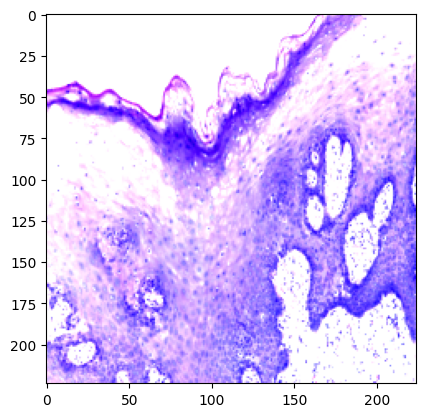

Sample 1 - Class: Normal
Sample 2 - Class: Normal
Sample 3 - Class: Normal
Sample 4 - Class: Normal
Sample 5 - Class: Normal


In [12]:
# Check a particular sample (first image in the dataset)
sample_image, sample_label = train_data[0]

# Display the sample image
import matplotlib.pyplot as plt
import numpy as np

# Convert tensor to numpy for display
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display the first image and label
print(f"Label: {train_data.classes[sample_label]}")
imshow(sample_image)

# Check specific samples
for idx in range(5):
    img, label = train_data[idx]
    print(f"Sample {idx+1} - Class: {train_data.classes[label]}")

Class: Cancerous (label index: 1)


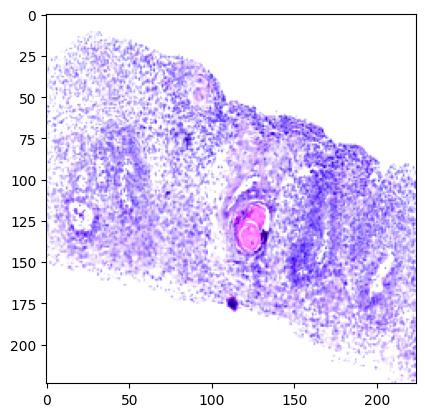

Class: Cancerous (label index: 1)


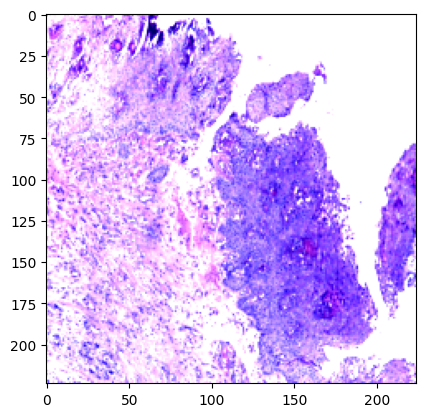

Class: Cancerous (label index: 1)


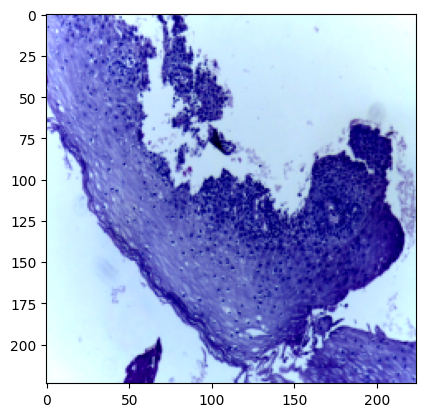

Class: Cancerous (label index: 1)


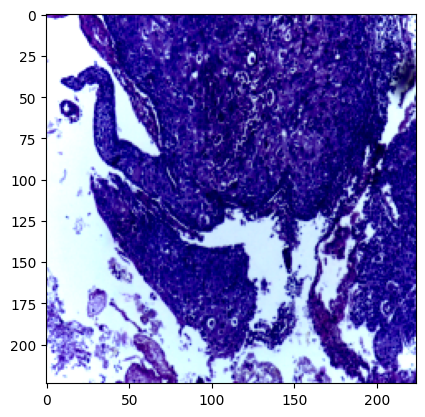

Class: Cancerous (label index: 1)


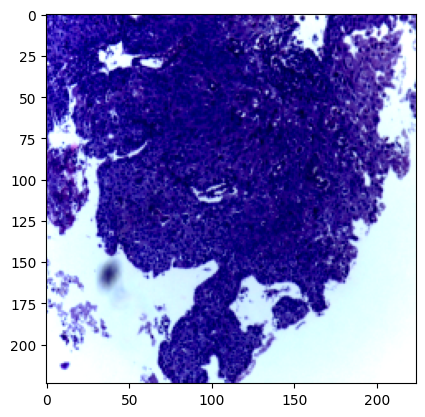

In [15]:
# Get the index for the 'cancerous' class
cancerous_idx = train_data.class_to_idx['OSCC']

# Define a function to display the images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Find and display some cancerous samples
cancerous_count = 0
for img, label in train_data:
    if label == cancerous_idx:
        print(f"Class: Cancerous (label index: {label})")
        imshow(img)
        cancerous_count += 1
    if cancerous_count == 5:  # Display only 5 images
        break

Random Image Label: Normal


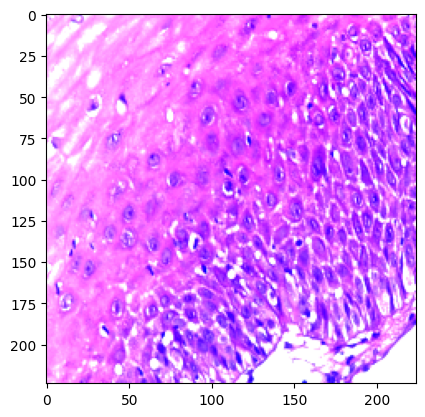

In [16]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display the image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Choose a random index from the dataset
random_idx = random.randint(0, len(train_data) - 1)

# Get the random image and label
random_image, random_label = train_data[random_idx]

# Print the class label
print(f"Random Image Label: {train_data.classes[random_label]}")

# Display the random image
imshow(random_image)


Actual Label: OSCC
Predicted Label: OSCC


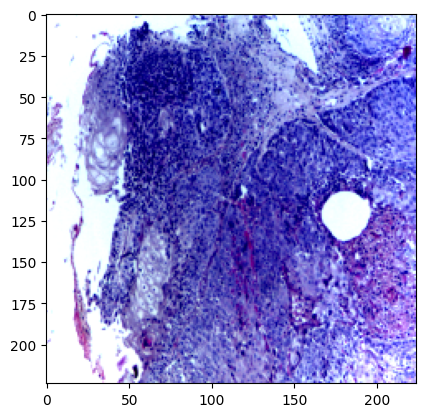

In [17]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define a function to display the image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Choose a random index from the dataset
random_idx = random.randint(0, len(train_data) - 1)

# Get the random image and label
random_image, random_label = train_data[random_idx]

# Move the image to the same device as the model
random_image = random_image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU/CPU

# Set the model to evaluation mode and get the prediction
model.eval()
with torch.no_grad():
    output = model(random_image)
    _, predicted = torch.max(output, 1)

# Get predicted and actual labels
predicted_label = predicted.item()
actual_label = random_label

# Print the predicted and actual labels
print(f"Actual Label: {train_data.classes[actual_label]}")
print(f"Predicted Label: {train_data.classes[predicted_label]}")

# Display the random image
imshow(random_image.cpu().squeeze())  # Move back to CPU for display